In [1]:
from interaction_inference import simulation, dataset
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tqdm
import numpy as np

In [2]:
rng = np.random.default_rng()

# Dispersion

Assuming data follows a Poisson distribution assumes that $mean = variance$, if the data has $mean < variance$ it is 'overdispersed' and if $mean > variance$ it is 'underdispersed'

Non-poisson data is typically overdispersed, and we show that this is the case for interacting birth-death data via simulations.

Unfortunately, moment optimization seems to remain feasible for overdispersed data, only becoming infeasible for underdispersed data, and again  show this is the case using simulated data.

Finally we investigate if higher moments (3rd, etc) can solve this issues, and detect interaction in overdispersed data.

# Interaction causes overdispersion

In [3]:
def custom_scatter(data, L, U, color, label):

    means = []
    variances = []

    for sample, moments in data.moments_OB.items():
        
        E_1 = np.mean(moments['E_x1'])
        E_2 = np.mean(moments['E_x2'])
        
        E_sq_1 = np.mean(moments['E_x1_sq'])
        E_sq_2 = np.mean(moments['E_x2_sq'])

        means.append(E_1)
        variances.append(E_sq_1 - E_1**2)

        means.append(E_2)
        variances.append(E_sq_2 - E_2**2)

    plt.scatter(means, variances, color=color, label=label)

    L = min(L, min(means), min(variances))
    U = max(U, max(means), max(variances))

    return L, U

In [4]:
samples = 10
intr = 5
rate = 5
data_BD_ind = simulation.simulate_dataset_range_BD("test", [0 for i in range(samples)], rate=rate, tqdm_disable=False)
data_BD_int = simulation.simulate_dataset_range_BD("test", [intr for i in range(samples)], rate=rate, tqdm_disable=False)
data_BD_ind.compute_moments()
data_BD_int.compute_moments()

100%|██████████| 10/10 [00:34<00:00,  3.40s/it]


In [5]:
b = 2
beta = rng.beta(1, b, size=1000)
data_BD_D_ind = data_BD_ind.downsample("test", beta)
data_BD_D_int = data_BD_int.downsample("test", beta)
data_BD_D_ind.compute_moments()
data_BD_D_int.compute_moments()

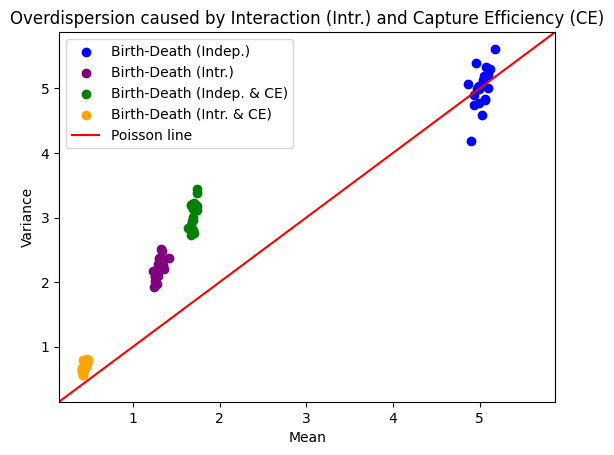

In [6]:
L = np.inf
U = 0
L, U = custom_scatter(data_BD_ind, L, U, "blue", "Birth-Death (Indep.)")
L, U = custom_scatter(data_BD_int, L, U, "purple", "Birth-Death (Intr.)")
L, U = custom_scatter(data_BD_D_ind, L, U, "green", "Birth-Death (Indep. & CE)")
L, U = custom_scatter(data_BD_D_int, L, U, "orange", "Birth-Death (Intr. & CE)")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Overdispersion caused by Interaction (Intr.) and Capture Efficiency (CE)")
plt.axline([L, L], [U, U], color="red", label="Poisson line")
plt.legend()

# Overdispersed feasible, Underdispersed infeasible

## Simulating over & under dispersion

## Moment optimization

# Higher moments